# **Mentoring 1** - Credit Scoring and Analytics
Sekolah Data - Pacmann

In [70]:
# Load data manipulation package
import numpy as np
import pandas as pd


# Load data visualization package
import matplotlib.pyplot as plt
import seaborn as sns
from platformdirs import user_data_dir
from scipy.ndimage import percentile_filter

from tqdm import tqdm

In [71]:
PATH_CREDIT_RECORD = "credit_record.csv"
PATH_APPLICATION_RECORD = "application_record.csv"

---
**Mentoring 1 to assess your understanding of these topics**:
1. Data Preparation
2. Data Exploration

in scorecard development process.

## **Case**: Credit Card Performance
---
This is a fictive datasets from [Credit Card Approval Prediction](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction).

We have a performance table:
- `credit_record.csv` contains the credit performance of debtors.

We don't have the target or response variable in this table.

Therefore, we have to assign the response variable according to our definition of 'bad' credit performance.

For simplicity, you can access the dataset for mentoring from this folder: [Folder Dataset](https://drive.google.com/drive/folders/12Ea7Ence5mfK0UL7DJ2CgFrev7Uhrj3t?usp=sharing)

### **Data Preparation**:
---
Load the performance data from `credit_record.csv` file.

Variable explanation:
- `ID` : The account's unique ID.
- `MONTHS_BALANCE` : The month of the extracted data is the starting point, backwards.
  - `MONTHS_BALANCE = 0` is the current month,
  - `MONTHS_BALANCE = -1` is the previous month,
  - and so on.
- `STATUS` : The status of the account's balance.
  - `0` : 1-29 days past due
  - `1` : 30-59 days past due
  - `2` : 60-89 days past due
  - `3` : 90-119 days past due
  - `4` : 120-149 days past due
  - `5` : write-offs or more than 150 days past due
  - `C` : paid off that month
  - `X` : no loan for the month

In [72]:
# Import dataset from csv file
performance_data = pd.read_csv(PATH_CREDIT_RECORD)

# Table check
performance_data.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [73]:
# Check the data shape
performance_data.shape

(1048575, 3)

  - Performance data contains 3 variables from 1,048,575 records.
  - Let's check how many unique IDs we have.

In [74]:
# Check the total of unique IDs
len(set(performance_data['ID']))

45985

In [75]:
# Check data randomly
id_random = performance_data.sample(1, random_state=32)['ID']
id_random

317044    5029543
Name: ID, dtype: int64

In [76]:
# Check data with that random id
condition = performance_data['ID'].isin(id_random)
random_performance = performance_data[condition]
random_performance

,ID,MONTHS_BALANCE,STATUS
317035,5029543,-30,C
317036,5029543,-31,C
317037,5029543,-32,C
317038,5029543,-33,C
317039,5029543,-34,C
317040,5029543,-35,C
317041,5029543,-36,0
317042,5029543,-37,0
317043,5029543,-38,0
317044,5029543,-39,0


In [77]:
# Check data randomly
id_random2 = performance_data.sample(1, random_state=432)['ID']
id_random2

103547    5009469
Name: ID, dtype: int64

In [78]:
# Check data with that random id
condition2 = performance_data['ID'].isin(id_random2)
random_performance2 = performance_data[condition2]
random_performance2

,ID,MONTHS_BALANCE,STATUS
103547,5009469,0,0
103548,5009469,-1,1
103549,5009469,-2,0
103550,5009469,-3,0
103551,5009469,-4,0
103552,5009469,-5,0
103553,5009469,-6,X


### **Data Cleansing**:

In [79]:
# Check if status is valid
# performance_data["STATUS"].value_counts()

In [80]:
# performance_data["MONTHS_BALANCE"].value_counts()

In [81]:
# only_x = performance_data.groupby("ID")["STATUS"].apply(lambda x: set(x) == {'X'})
# only_x_ids = only_x[only_x].index.tolist()

# performance_data = performance_data[~performance_data["ID"].isin(only_x_ids)]

In [82]:
# first_month_users = performance_data.groupby("ID")["MONTHS_BALANCE"].max().sort_values(ascending=True)

In [83]:
# first_month_users[first_month_users < 0].shape

In [84]:
# performance_data["ID"].nunique()

In [85]:
# performance_data[performance_data["ID"] == 5035920]

### **Question 1**:
What is the bad rate for a “bad” definition of 60+ days past due (DPD)?

---

**Expected Answer**:
```

print(f"The bad rate for a bad definition of 60+ DPD is about {bad_rate*100:.2f}%.")
```

In [86]:
# Get Bad-Rate User
# Formula to calculate bad-rate : (bad_user_ids/all_user_ids)
def has_60_plus_pass_due(x):
    statuses = {"2", "3", "4", "5"}
    x = set(x)
    return len(statuses.intersection(x)) > 0

bad_rate_users = performance_data.groupby("ID")["STATUS"].apply(lambda x: has_60_plus_pass_due(x.values))
bad_rate_users = bad_rate_users[bad_rate_users].index.tolist()
all_users = performance_data["ID"].nunique()

bad_rate = len(bad_rate_users) / all_users
print(f"The bad rate for a bad definition of 60+ DPD is about {bad_rate*100:.2f}%.")

The bad rate for a bad definition of 60+ DPD is about 1.45%.


### **Question 2**:

- How long do most people typically take to repay their loans?


[Hint: Use window repayment lenght and check the distribution before deciding the aggregation method]

**Expected Answer**:
```

print(f"Most people do repay their loan for {abs(int(loan_repayment_lenght))} month.")
```

In [87]:
end_month = performance_data.groupby("ID")["MONTHS_BALANCE"].max()
open_month = performance_data.groupby("ID")["MONTHS_BALANCE"].min()

repayment_data = pd.merge(open_month, end_month, on="ID")
repayment_data.index.name = "id"
repayment_data.columns = columns=["open_month", "end_month"]
repayment_data["window"] = repayment_data["end_month"] - repayment_data["open_month"]
repayment_data.head()

,open_month,end_month,window
id,,,
5001711,-3,0,3
5001712,-18,0,18
5001713,-21,0,21
5001714,-14,0,14
5001715,-59,0,59


In [88]:
print(f"Most people do repay their loan for 21.8 month.")

Most people do repay their loan for 21.8 month.


### **Question 3**:
What is the bad rate for a “bad” definition of 90+ days past due (DPD)?

---

**Expected Answer**:

```
print(f"The bad rate for a bad definition of 90+ DPD is about {bad_rate_90*100:.2f}%.")
```

In [89]:
# Get Bad-Rate User
# Formula to calculate bad-rate : (bad_user_ids/all_user_ids)
def has_60_plus_pass_due(x):
    statuses = {"3", "4", "5"}
    x = set(x)
    return len(statuses.intersection(x)) > 0

bad_rate_users = performance_data.groupby("ID")["STATUS"].apply(lambda x: has_60_plus_pass_due(x.values))
bad_rate_users = bad_rate_users[bad_rate_users].index.tolist()
all_users = performance_data["ID"].nunique()

bad_rate = len(bad_rate_users) / all_users
print(f"The bad rate for a bad definition of 60+ DPD is about {bad_rate*100:.2f}%.")

The bad rate for a bad definition of 60+ DPD is about 0.72%.


### **Question 4**:
Assume that the bad loan as an account whose loan status is writte-off (WO).
- Plot Cohort Table for Bad Rate
- Plot the most recent bad rate from each cohort (open month).
- Also define the performance window based on the bad rate cohort
---

In [90]:
performance_data = performance_data.copy()

write_off = performance_data['STATUS'] == '5'
performance_data["write_off"] = np.where(write_off, 1, 0)

performance_data

,ID,MONTHS_BALANCE,STATUS,write_off
0,5001711,0,X,0
1,5001711,-1,0,0
2,5001711,-2,0,0
3,5001711,-3,0,0
4,5001712,0,C,0
...,...,...,...,...
1048570,5150487,-25,C,0
1048571,5150487,-26,C,0
1048572,5150487,-27,C,0
1048573,5150487,-28,C,0


In [91]:
performance_pivot = performance_data.pivot(
    index="ID",
    columns="MONTHS_BALANCE",
    values="STATUS",
)
performance_pivot.head()

MONTHS_BALANCE,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,...,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
ID,,,,,,,,,,,,,,,,,,,,,
5001711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,X
5001712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,C,C,C,C,C,C,C,C,C
5001713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,X,X
5001714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,X,X
5001715,NaN,X,X,X,X,X,X,X,X,X,...,X,X,X,X,X,X,X,X,X,X


In [92]:
# Make an object to group the performance data by ID
each_ids = performance_data.groupby('ID')

# Define the open month = when the credit is activated/payout
performance_pivot['open_month'] = each_ids['MONTHS_BALANCE'].min()
# Define the end month = last record of the credit performance
performance_pivot["end_month"] = each_ids['MONTHS_BALANCE'].max()
# Calculate the performance window
performance_pivot["window"] = performance_pivot["end_month"] - performance_pivot["open_month"]

# Use only some columns
performance_pivot["ID"] = performance_pivot.index
performance_pivot.reset_index(drop=True, inplace=True)
performance_pivot = performance_pivot[["ID", "open_month", "end_month", "window"]]

# display the data
performance_pivot

MONTHS_BALANCE,ID,open_month,end_month,window
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59
...,...,...,...,...
45980,5150482,-28,-11,17
45981,5150483,-17,0,17
45982,5150484,-12,0,12
45983,5150485,-1,0,1


In [52]:
performance_data.head()

,ID,MONTHS_BALANCE,STATUS,write_off
0,5001711,0,X,0
1,5001711,-1,0,0
2,5001711,-2,0,0
3,5001711,-3,0,0
4,5001712,0,C,0


In [55]:
performance = pd.merge(
    left=performance_data, right=performance_pivot,
    how="left", on="ID"
)

performance

,ID,MONTHS_BALANCE,STATUS,write_off,open_month,end_month,window
0,5001711,0,X,0,-3,0,3
1,5001711,-1,0,0,-3,0,3
2,5001711,-2,0,0,-3,0,3
3,5001711,-3,0,0,-3,0,3
4,5001712,0,C,0,-18,0,18
...,...,...,...,...,...,...,...
1048570,5150487,-25,C,0,-29,0,29
1048571,5150487,-26,C,0,-29,0,29
1048572,5150487,-27,C,0,-29,0,29
1048573,5150487,-28,C,0,-29,0,29


In [57]:
# Calculate the month on books or cohort index
performance['month_on_books'] = performance['MONTHS_BALANCE'] - performance['open_month']

performance

,ID,MONTHS_BALANCE,STATUS,write_off,open_month,end_month,window,month_on_books
0,5001711,0,X,0,-3,0,3,3
1,5001711,-1,0,0,-3,0,3,2
2,5001711,-2,0,0,-3,0,3,1
3,5001711,-3,0,0,-3,0,3,0
4,5001712,0,C,0,-18,0,18,18
...,...,...,...,...,...,...,...,...
1048570,5150487,-25,C,0,-29,0,29,4
1048571,5150487,-26,C,0,-29,0,29,3
1048572,5150487,-27,C,0,-29,0,29,2
1048573,5150487,-28,C,0,-29,0,29,1


In [66]:
# Make an object to group the pivot table by open_month
each_cohort = performance_pivot.groupby(['open_month'])

# Calculate the total IDs of each cohort month
total_account_table = each_cohort.agg({'ID': ['count']})
total_account_table

MONTHS_BALANCE,ID
,count
open_month,
-60,415
-59,406
-58,440
-57,400
-56,470
...,...
-4,874
-3,919


In [67]:
# Reset index and rename the column
total_account_table.reset_index(inplace = True)
total_account_table.columns = ['open_month','total_account']

total_account_table

,open_month,total_account
0,-60,415
1,-59,406
2,-58,440
3,-57,400
4,-56,470
...,...,...
56,-4,874
57,-3,919
58,-2,771
59,-1,686


In [60]:
# Sanity check
total_account_table['total_account'].sum()

np.int64(45985)

In [62]:
# Calculate total accounts/IDs for cohort table
cohort = performance.groupby(['open_month','month_on_books']).agg({'ID': ['count']})

# Display the calculation
cohort

ID
                          count
open_month month_on_books      
-60        0                415
           1                414
           2                410
           3                408
           4                403
...                         ...
-2         1                770
           2                750
-1         0                686
           1                682
 0         0                370

[1891 rows x 1 columns]

In [63]:
# Reset index and rename columns
cohort.reset_index(inplace = True)
cohort.columns = ['open_month', 'month_on_books', 'total_account_per_mob']

cohort

,open_month,month_on_books,total_account_per_mob
0,-60,0,415
1,-60,1,414
2,-60,2,410
3,-60,3,408
4,-60,4,403
...,...,...,...
1886,-2,1,770
1887,-2,2,750
1888,-1,0,686
1889,-1,1,682


In [64]:
# Sanity check
cohort[cohort['month_on_books'] == 0]['total_account_per_mob'].sum()

np.int64(45985)

In [68]:
performance_pivot.head()

MONTHS_BALANCE,ID,open_month,end_month,window
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59


In [93]:
# Check the pivot for booking at open_month = -60
performance_pivot[performance_pivot['open_month'] == -60]

MONTHS_BALANCE,ID,open_month,end_month,window
15,5001730,-60,0,60
346,5002160,-60,0,60
351,5002165,-60,0,60
355,5002171,-60,0,60
444,5002283,-60,0,60
...,...,...,...,...
44745,5148718,-60,-1,59
44827,5148819,-60,0,60
45016,5149057,-60,-27,33
45240,5149355,-60,-21,39


In [94]:
# Use only some columns, we will replace total_account_per_mob
cohort = cohort[['open_month','month_on_books']]

# Merge total_accounts and cohort table, thus we have column total_account
cohort = pd.merge(left = cohort,
                  right = total_account_table,
                  how = 'left',
                  on = ['open_month'])

cohort

,open_month,month_on_books,total_account
0,-60,0,415
1,-60,1,415
2,-60,2,415
3,-60,3,415
4,-60,4,415
...,...,...,...
1886,-2,1,771
1887,-2,2,771
1888,-1,0,686
1889,-1,1,686


In [289]:
# Create a column to store the total of bad accounts
cohort['total_bad'] = np.nan

cohort

/var/folders/zk/brzgnbks3bb5n5z8_bd3rvrm0000gn/T/ipykernel_39090/4064053576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort['total_bad'] = np.nan


,open_month,month_on_books,total_account,total_bad,bad_rate
1188,-36,0,635,NaN,0.0
1189,-36,1,635,NaN,0.0
1190,-36,2,635,NaN,0.0
1191,-36,3,635,NaN,0.0
1192,-36,4,635,NaN,0.0
...,...,...,...,...,...
1886,-2,1,670,NaN,0.0
1887,-2,2,670,NaN,0.0
1888,-1,0,574,NaN,0.0
1889,-1,1,574,NaN,0.0


In [290]:
# Use only open_month >= -36 (last 3 years booking)
max_open = -36
max_window = -(max_open)

# Define new cohort
cohort_dup = cohort.copy()
cohort = cohort[cohort['open_month'] >= max_open]

cohort

,open_month,month_on_books,total_account,total_bad,bad_rate
1188,-36,0,635,NaN,0.0
1189,-36,1,635,NaN,0.0
1190,-36,2,635,NaN,0.0
1191,-36,3,635,NaN,0.0
1192,-36,4,635,NaN,0.0
...,...,...,...,...,...
1886,-2,1,670,NaN,0.0
1887,-2,2,670,NaN,0.0
1888,-1,0,574,NaN,0.0
1889,-1,1,574,NaN,0.0


In [291]:
# Count the total_bad for each month_on_books in each open_month
for open in range(max_open, 1):

  # Initialize a list to store bad accounts
  bad_list = []

  # Define bad loan, month_on_book, and open_month
  bad = performance['write_off']
  month_on_book = performance['month_on_books']
  open_month = performance['open_month']

  for mob in range(0, max_window+1):

    # Define bad account
    bad_ID = list(performance[(bad == 1) & (month_on_book == mob) & (open_month == open)]['ID'])

    # Store the bad account in bad_list
    bad_list.extend(bad_ID)

    # Count the total_bad ID in each month_on_book
    bad_counts = len(set(bad_list))

    # Store the total_bad ID in cohort table
    cohort.loc[(cohort['month_on_books'] == mob) & (cohort['open_month'] == open), 'total_bad'] = bad_counts

# Create and calculate column bad_rate in cohort table
cohort['bad_rate']  = cohort['total_bad'] / cohort['total_account']

cohort

,open_month,month_on_books,total_account,total_bad,bad_rate
1188,-36,0,635,0.0,0.0
1189,-36,1,635,0.0,0.0
1190,-36,2,635,0.0,0.0
1191,-36,3,635,0.0,0.0
1192,-36,4,635,0.0,0.0
...,...,...,...,...,...
1886,-2,1,670,0.0,0.0
1887,-2,2,670,0.0,0.0
1888,-1,0,574,0.0,0.0
1889,-1,1,574,0.0,0.0


In [292]:
# Pivot the cohort table
cohort_pivot = cohort.pivot(index = 'open_month',
                            columns = 'month_on_books',
                            values = 'bad_rate')

cohort_pivot

month_on_books,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
open_month,,,,,,,,,,,,,,,,,,,,,
-36,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003150,...,0.007874,0.007874,0.007874,0.007874,0.007874,0.007874,0.009449,0.009449,0.009449,0.009449
-35,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002903,0.002903,0.002903,0.002903,0.002903,0.002903,0.002903,0.002903,0.002903,NaN
-34,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.007496,0.007496,0.007496,0.007496,0.007496,0.007496,0.007496,0.007496,NaN,NaN
-33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001543,0.003086,0.003086,0.003086,0.003086,0.003086,0.004630,NaN,NaN,NaN
-32,0.0,0.0,0.001475,0.001475,0.001475,0.001475,0.001475,0.001475,0.001475,0.001475,...,0.004425,0.004425,0.004425,0.004425,0.004425,0.004425,NaN,NaN,NaN,NaN
-31,0.0,0.0,0.001451,0.001451,0.001451,0.001451,0.001451,0.002903,0.002903,0.002903,...,0.005806,0.005806,0.005806,0.005806,0.005806,NaN,NaN,NaN,NaN,NaN
-30,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001385,0.001385,...,0.008310,0.008310,0.008310,0.008310,NaN,NaN,NaN,NaN,NaN,NaN
-29,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001395,...,0.002789,0.002789,0.002789,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-28,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002717,0.004076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


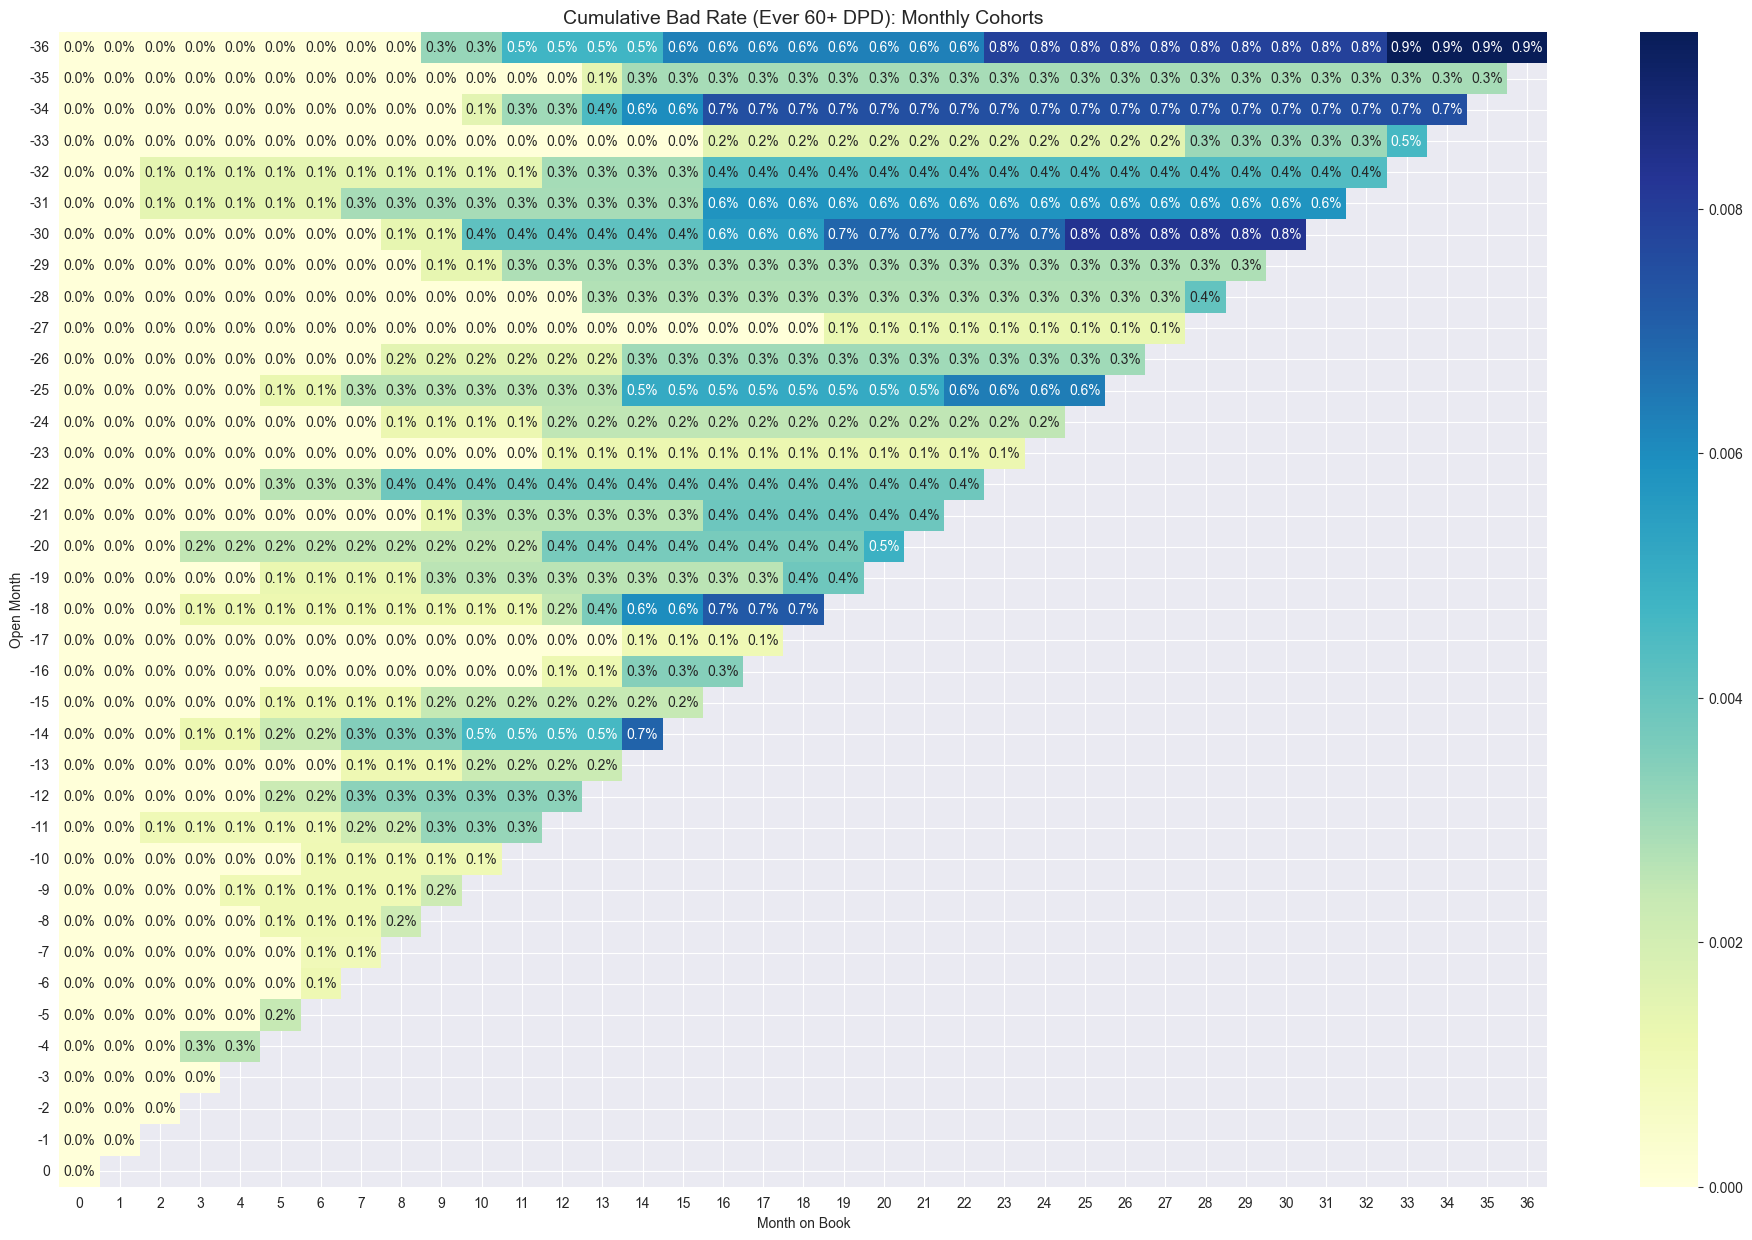

In [293]:
# Vizualise the cohort in heatmap
plt.figure(figsize = (24,15))

plt.title('Cumulative Bad Rate (Ever 60+ DPD): Monthly Cohorts',
          fontsize = 14)

# Create the heatmap
sns.heatmap(data = cohort_pivot,
            annot = True,
            fmt = '.1%',
            cmap = 'YlGnBu')

plt.ylabel('Open Month')
plt.xlabel('Month on Book')
plt.yticks(rotation = 'horizontal')
plt.show()

## Define Performance and Sample Window ##

In [294]:
# Transform picot table into df
window_list = []
for i in range(max_open, 1):
  window_list.append(i)

cohort_table = cohort_pivot.loc[window_list]
cohort_table

month_on_books,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
open_month,,,,,,,,,,,,,,,,,,,,,
-36,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003150,...,0.007874,0.007874,0.007874,0.007874,0.007874,0.007874,0.009449,0.009449,0.009449,0.009449
-35,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002903,0.002903,0.002903,0.002903,0.002903,0.002903,0.002903,0.002903,0.002903,NaN
-34,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.007496,0.007496,0.007496,0.007496,0.007496,0.007496,0.007496,0.007496,NaN,NaN
-33,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001543,0.003086,0.003086,0.003086,0.003086,0.003086,0.004630,NaN,NaN,NaN
-32,0.0,0.0,0.001475,0.001475,0.001475,0.001475,0.001475,0.001475,0.001475,0.001475,...,0.004425,0.004425,0.004425,0.004425,0.004425,0.004425,NaN,NaN,NaN,NaN
-31,0.0,0.0,0.001451,0.001451,0.001451,0.001451,0.001451,0.002903,0.002903,0.002903,...,0.005806,0.005806,0.005806,0.005806,0.005806,NaN,NaN,NaN,NaN,NaN
-30,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001385,0.001385,...,0.008310,0.008310,0.008310,0.008310,NaN,NaN,NaN,NaN,NaN,NaN
-29,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001395,...,0.002789,0.002789,0.002789,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-28,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002717,0.004076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [295]:
# Define the initial list for the diagonal bad rates
diagonal = []

# Find the bad rate and store in the list
for booking in range(0, max_window+1):
  diag_bad_rate = cohort_table[booking][-booking]
  diagonal.append(diag_bad_rate)

# Display the result
diagonal = pd.DataFrame(diagonal)
diagonal.T

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0.0,0.0,0.0,0.0,0.002564,0.002364,0.001112,0.000986,0.002181,0.00221,...,0.001307,0.004076,0.002789,0.00831,0.005806,0.004425,0.00463,0.007496,0.002903,0.009449


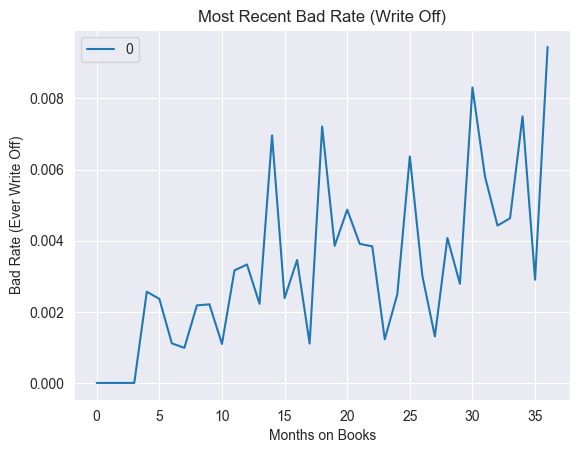

In [296]:
# Plot the cumulative bad rate of the single cohorts
diagonal.plot(title = 'Most Recent Bad Rate (Write Off)',
                     kind = 'line',
                     grid = True,
                     legend = True)

plt.xlabel('Months on Books')
plt.ylabel('Bad Rate (Ever Write Off)')
plt.show()

### **Question 5**:
---

- Create a plot to compare cumulative bad rate between Accounts opened in 24, 36, 48, and 60 months ago
- Analyze the cumulative bad rate and provide insights that related to the sample window
- Based on the maturity curves you've created, if the sample window is four years ago (`open_month = -48`), what would the performance window be?
- Can we choose `open_month = -60` as the sample window? Why?

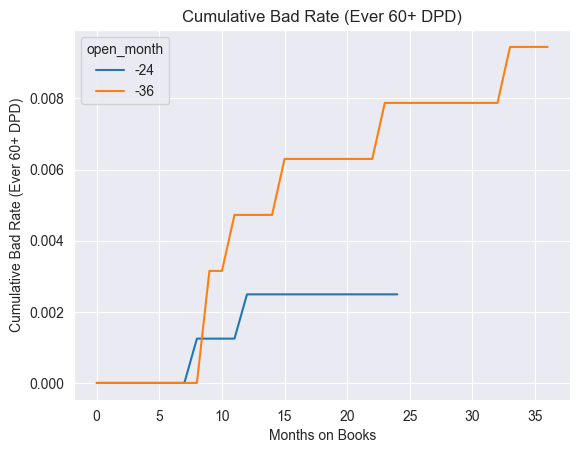

In [297]:
# Define the single cohort
list_of_booking = [-24,-36]

# Store in a dataframe
try:
    cohort_sliced = cohort_pivot.loc[list_of_booking]
except:
    pass

# Plot the cumulative bad rate of the single cohorts
cohort_sliced.T.plot(title = 'Cumulative Bad Rate (Ever 60+ DPD)',
                     kind = 'line',
                     grid = True,
                     legend = True)

plt.xlabel('Months on Books')
plt.ylabel('Cumulative Bad Rate (Ever 60+ DPD)')
plt.show()

In [298]:
# Sample window: open_month between 0 and -36 ---> -36 <= open_month <= 0
# Define min and max of open_month
max_open = -36
min_open = -35

# Define min and max of sample window
min_window = performance['open_month'] <= min_open
max_window = performance['open_month'] >= max_open

# Define sample window
sample_window = performance[(min_window) & (max_window)]

sample_window

,ID,MONTHS_BALANCE,STATUS,write_off,open_month,end_month,window,month_on_books
127,5001720,0,1,0,-35,0,35,35
128,5001720,-1,0,0,-35,0,35,34
129,5001720,-2,0,0,-35,0,35,33
130,5001720,-3,1,0,-35,0,35,32
131,5001720,-4,1,0,-35,0,35,31
...,...,...,...,...,...,...,...,...
945067,5150229,-31,0,0,-35,0,35,4
945068,5150229,-32,0,0,-35,0,35,3
945069,5150229,-33,0,0,-35,0,35,2
945070,5150229,-34,0,0,-35,0,35,1


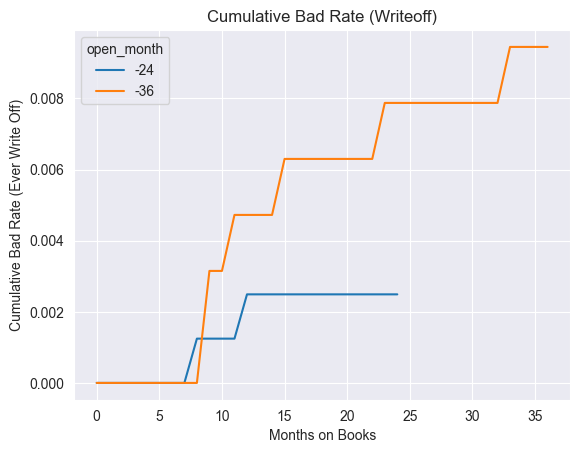

In [299]:
# Plot the cumulative bad rate of the single cohorts
cohort_sliced.T.plot(title = 'Cumulative Bad Rate (Writeoff)',
                     kind = 'line',
                     grid = True,
                     legend = True)

plt.xlabel('Months on Books')
plt.ylabel('Cumulative Bad Rate (Ever Write Off)')
plt.show()

### **Question 6**:
---

- Create plots and compare the most recent bad rate using different  bad definition status:
    - `2` : 60-89 days past due
    - `3` : 90-119 days past due
    - `4` : 120-149 days past due
    - `5` : write-offs or more than 150 days past due

- Provide analysis of the most recent bad rate each of the status (Diagonal Cohort/The Most recent bad rate), compare each most recent bad rate according to all bad definition status

- Provide analysis, conclusion, and recommendation to sample window & sample window **using single cohort** in every bad status definition with these different open month: `[-36, -35, -25, -24]`

### **Question 7**:
---

- Read the `"application_record.csv"` from the dataset folder [Folder Dataset](https://drive.google.com/drive/folders/12Ea7Ence5mfK0UL7DJ2CgFrev7Uhrj3t?)
- Create bad_table for each bad definition status, create bad status as response variable in each bad definition status, and merge data with application data.
- Make it as a function `get_final_data(performance_data, application_data, bad_status_column, max_open=-36, min_open=-35)` with input open month default: `max_open = -36` and `min_open = -35` with output merged dataset
- Compare proportion between bad(1) and not bad(0) using `value_counts(normalize=True)` between all bad definition status from merged dataset
- Save all your data in csv format with these file name:
    - `dpd_60_data.csv`
    - `dpd_90_data.csv`
    - `dpd_120_data.csv`
    - `dpd_wo_data.csv`



Function example:
```
def get_final_data(performance_data, application_data, bad_status_column, max_open=-36, min_open=-35):
    """
    Function to get final data
    """

    # YOUR CODE HERE
    ...
    ...


    return data


# Example of usage
data = get_final_data(performance_data = performace,
                      application_data,
                      bad_status_column = "60+DPD",
                      max_open = -36,
                      min_open = -35)


```

Expected output:
- Cleaned application data from any ID duplicates
- 4 merged data given format and name above
- Cleaned from missing values
- Columns: `ID, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE,  NAME_FAMILY_STATUS,	NAME_HOUSING_TYPE, DAYS_BIRTH, DAYS_EMPLOYED, FLAG_MOBIL, FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, open_month, BAD.`